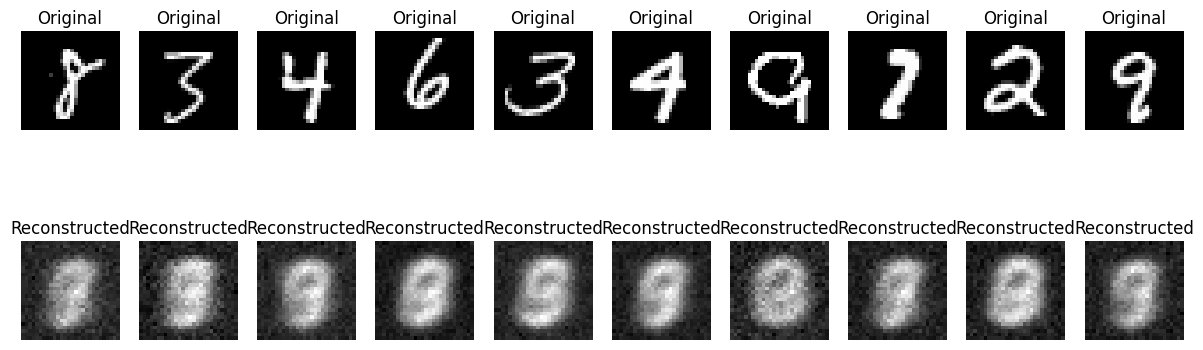

Epoch 1/4 - VAE Loss: 98.7719 - GAN Loss: 0.0000 - Recon Loss: 82.2167 - KL Loss: 0.3311


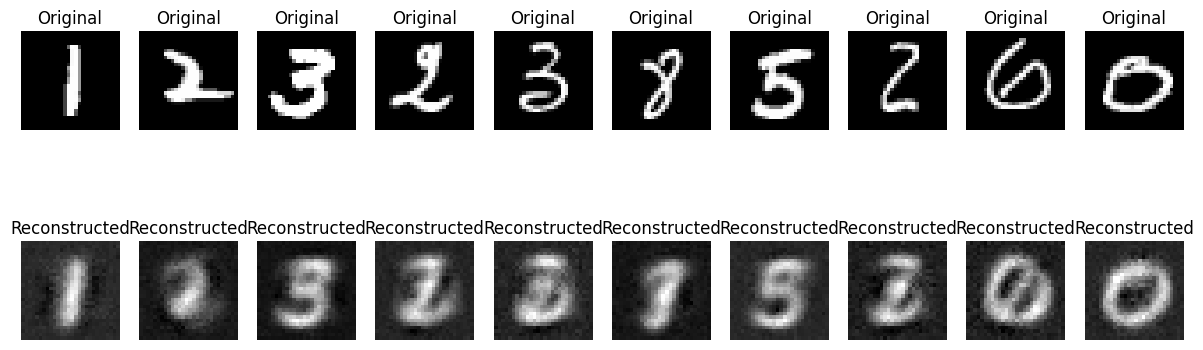

Epoch 2/4 - VAE Loss: 113.8190 - GAN Loss: 0.0000 - Recon Loss: 36.8251 - KL Loss: 1.5399


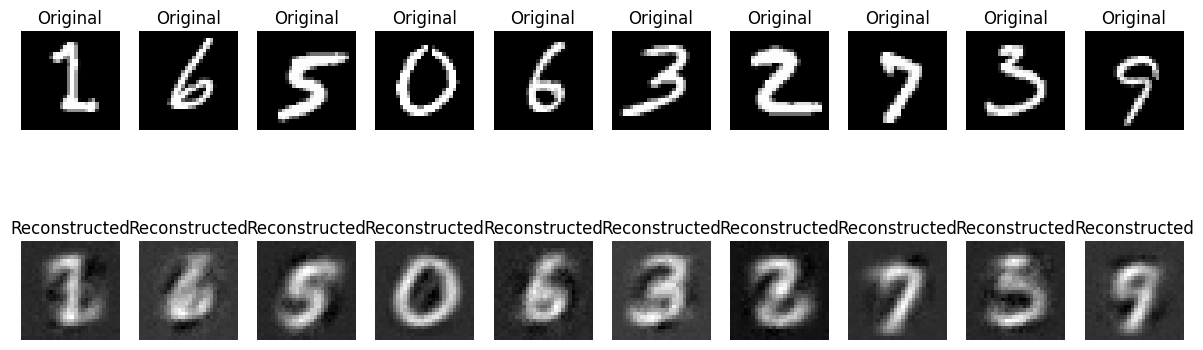

Epoch 3/4 - VAE Loss: 173.7808 - GAN Loss: 0.0000 - Recon Loss: 25.4882 - KL Loss: 2.9659


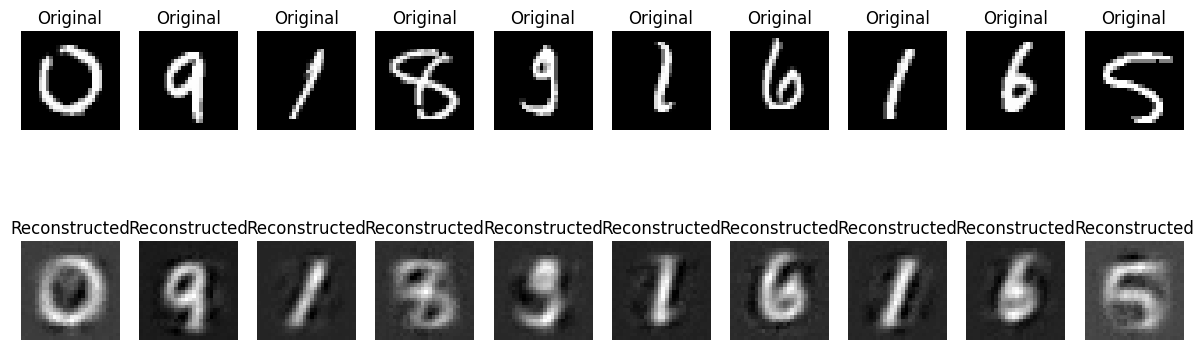

Epoch 4/4 - VAE Loss: 222.0664 - GAN Loss: 0.0000 - Recon Loss: 20.1386 - KL Loss: 4.0386


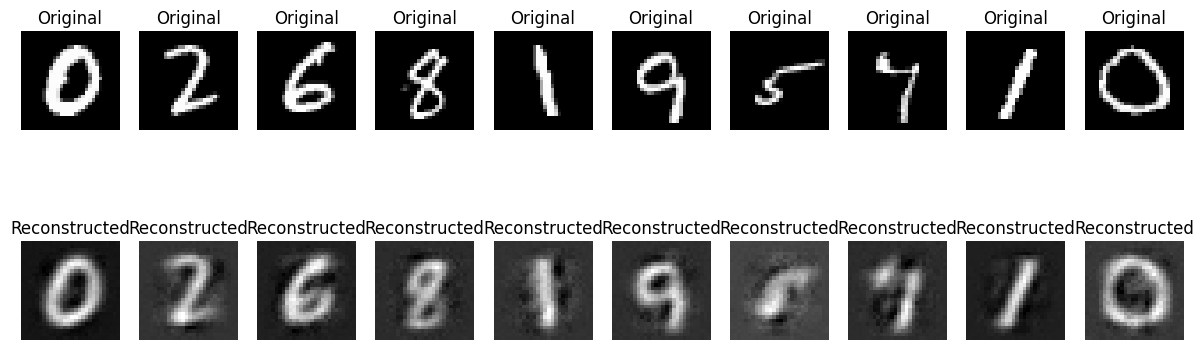

In [1]:
from VAE import Encoder, Decoder, Discriminator, VAEGANTrainer, GAN_, visualize_reconstruction
from tensorflow.keras.datasets import mnist
import numpy as np

# Инициализация
# Инициализация
# Подготовка данных
def preprocess_data(x):
    x = x.astype('float32') / 255.0
    return x.reshape(x.shape[0], -1)

# Загрузка данных MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = preprocess_data(x_train)

# Инициализация моделей
encoder = Encoder(learning_rate= 1e-4) # Ниже 1e-6 значения kl улаетает \
decoder = Decoder(learning_rate=1e-5)
# Обучение
trainer_VAE = VAEGANTrainer(encoder, decoder, beta=0.02) #0.05

trainer_VAE.train(x_train, batch_size=16, epochs=4) #20
visualize_reconstruction(decoder=decoder, encoder=encoder, test_data=x_test)

In [2]:
dicter = {}
for i in trainer_VAE.__dict__:
    dicter[i] = trainer_VAE.__dict__[i]

In [3]:
for i in dicter:
    trainer_VAE.__dict__[i] = dicter[i]

In [4]:
trainer_VAE.beta

0.02

In [5]:
discriminator = Discriminator(learning_rate=1e-7)

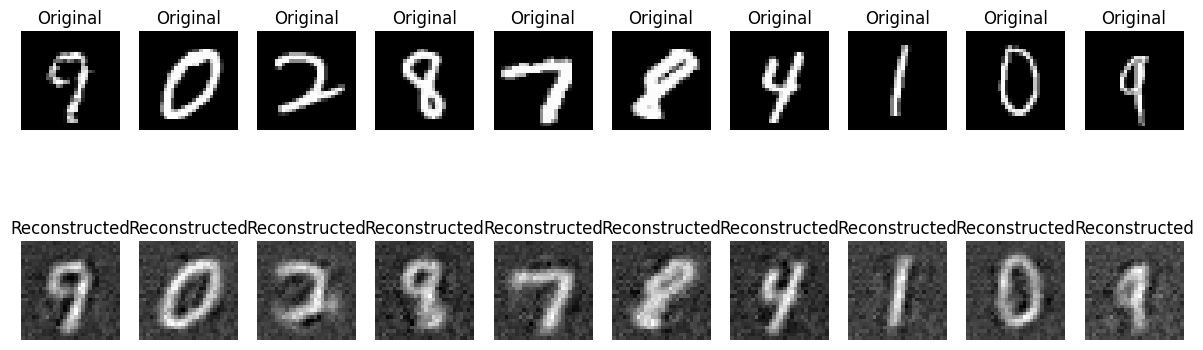

Epoch 1/10 - D Loss: 0.0000 - G Loss: 0.1688 - Recon: 18.0797 - Kl loss: 281.8109 


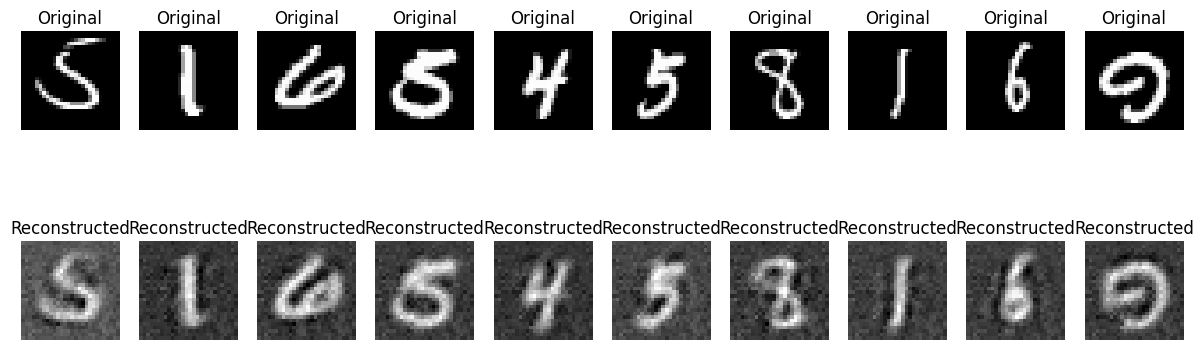

Epoch 2/10 - D Loss: 0.0000 - G Loss: 0.1584 - Recon: 15.4250 - Kl loss: 356.9197 


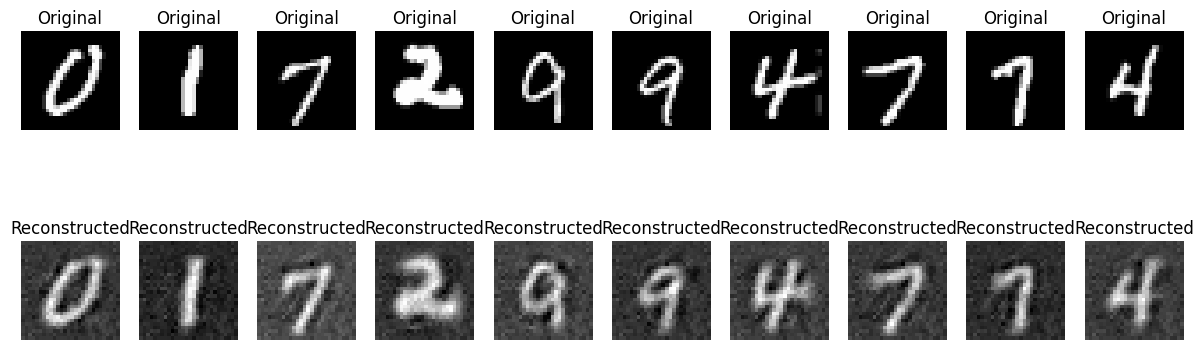

Epoch 3/10 - D Loss: 0.0000 - G Loss: 0.2005 - Recon: 14.0237 - Kl loss: 402.8898 


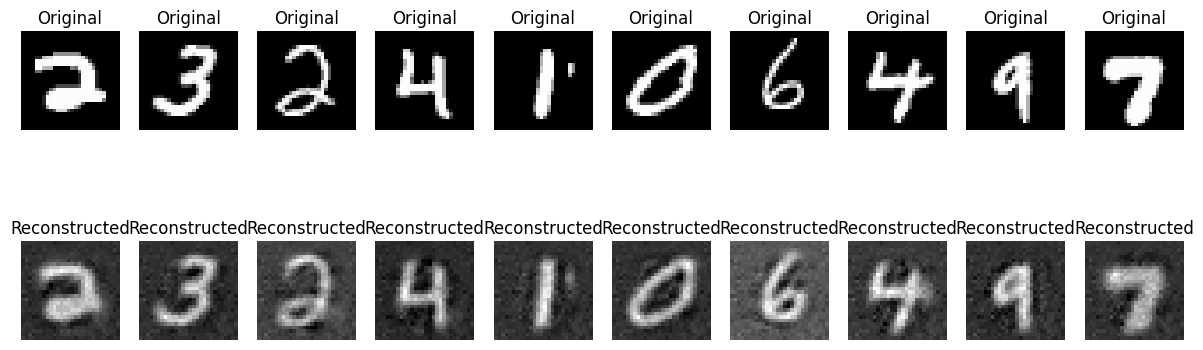

Epoch 4/10 - D Loss: 0.0000 - G Loss: 0.2946 - Recon: 13.2548 - Kl loss: 432.0098 


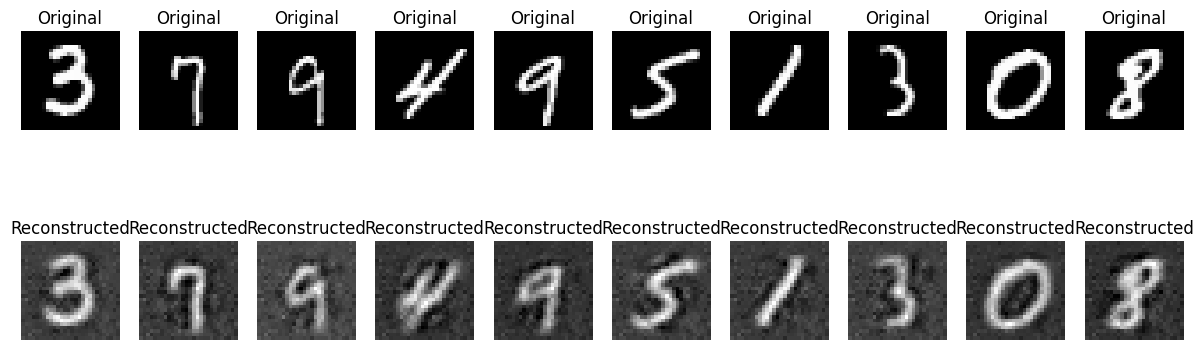

Epoch 5/10 - D Loss: 0.0000 - G Loss: 0.3332 - Recon: 12.8156 - Kl loss: 451.6097 


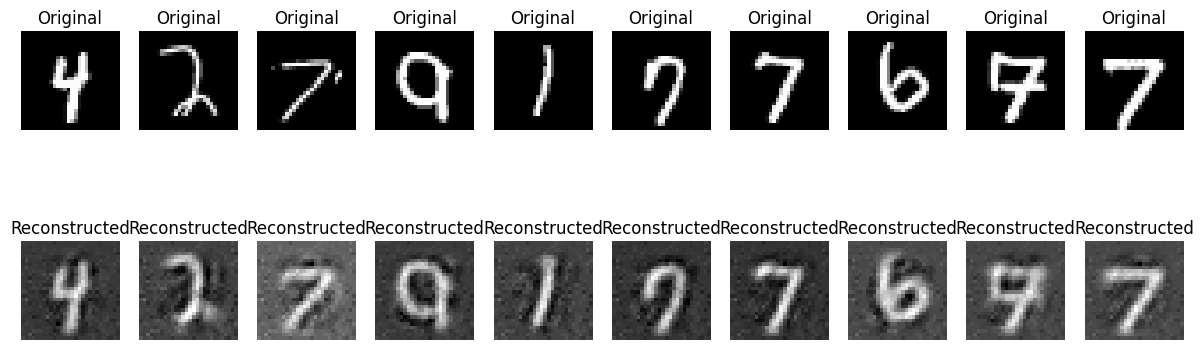

Epoch 6/10 - D Loss: 0.0000 - G Loss: 0.3421 - Recon: 12.5931 - Kl loss: 466.1172 


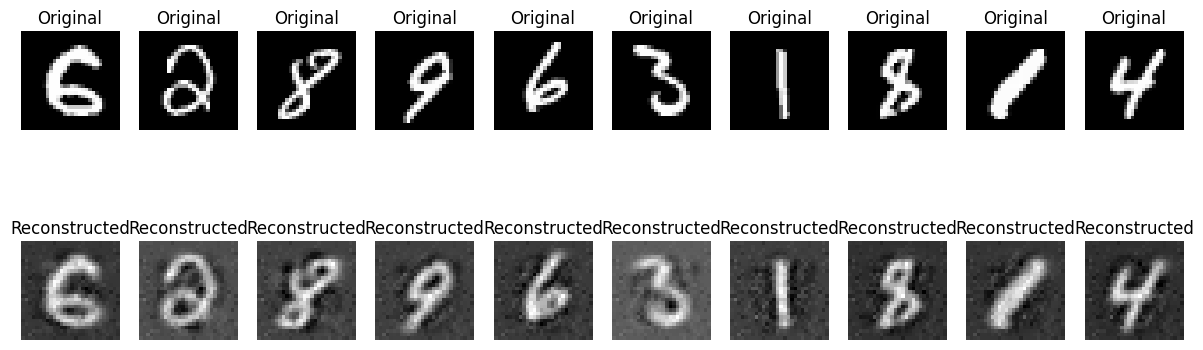

Epoch 7/10 - D Loss: 0.0000 - G Loss: 0.3445 - Recon: 12.5600 - Kl loss: 477.3107 


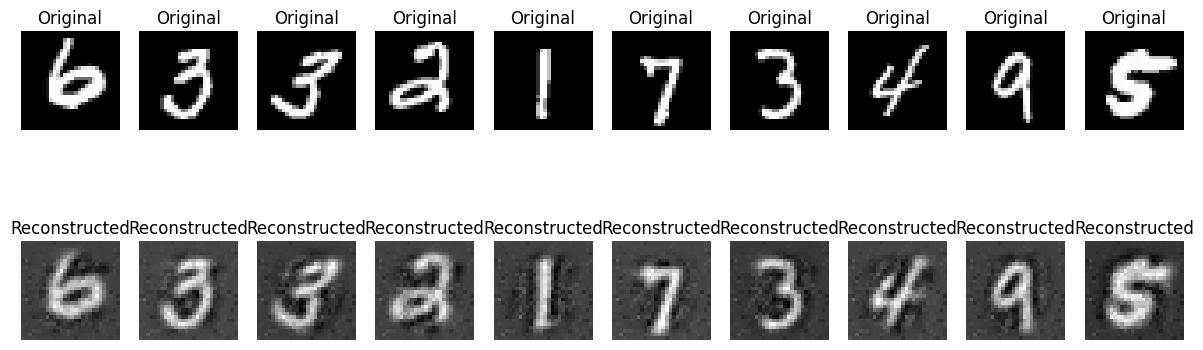

Epoch 8/10 - D Loss: 0.0000 - G Loss: 0.3453 - Recon: 12.6912 - Kl loss: 486.0045 


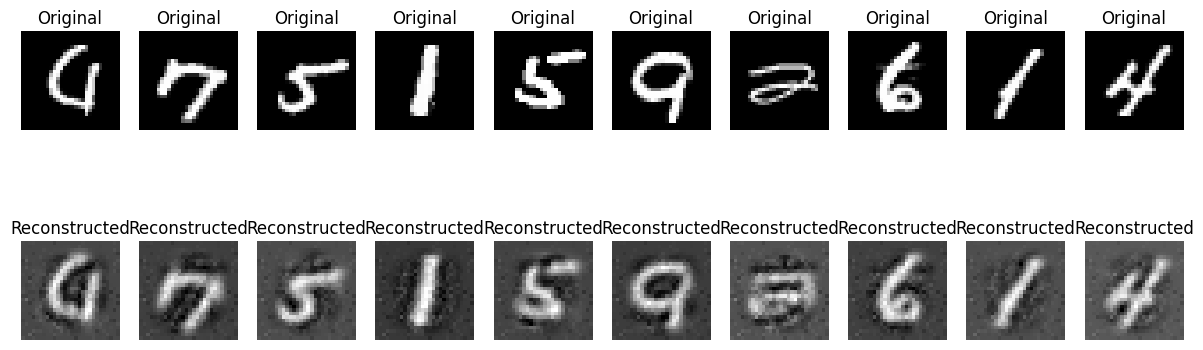

Epoch 9/10 - D Loss: 0.0000 - G Loss: 0.3455 - Recon: 12.9713 - Kl loss: 492.3424 


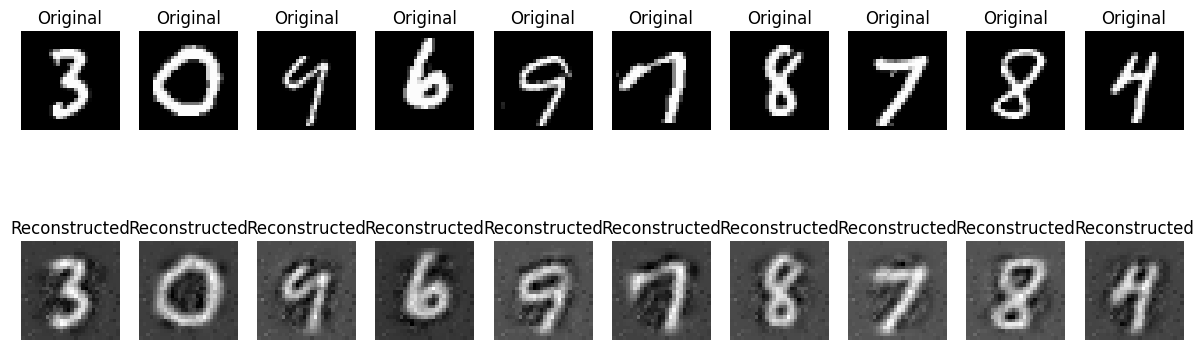

Epoch 10/10 - D Loss: 0.0000 - G Loss: 0.3454 - Recon: 13.4086 - Kl loss: 496.8669 


In [6]:
trainer_VAE.dec_lam = 2
trainer_VAE.beta = 0.0001
trainer_GAN = GAN_("h",trainer_VAE, discriminator=discriminator)
trainer_GAN.train(x_train=x_train, batch_size=16, epochs=10)

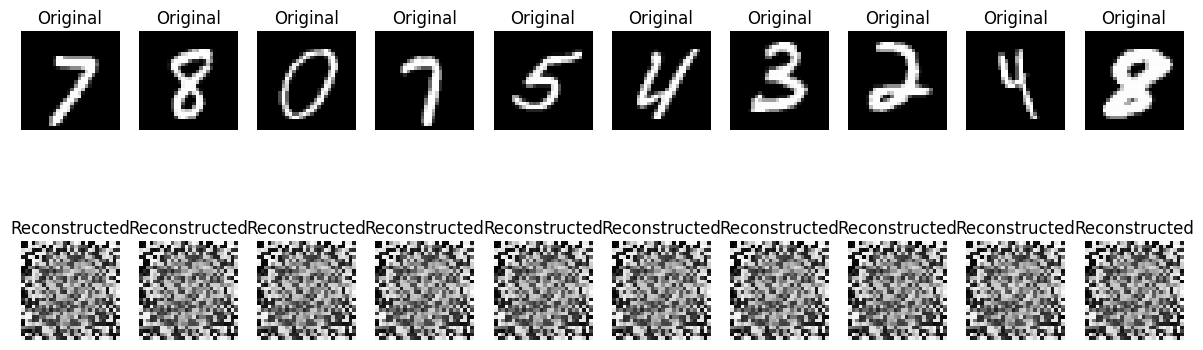

In [22]:
visualize_reconstruction(decoder=decoder, encoder=encoder, test_data=x_test)

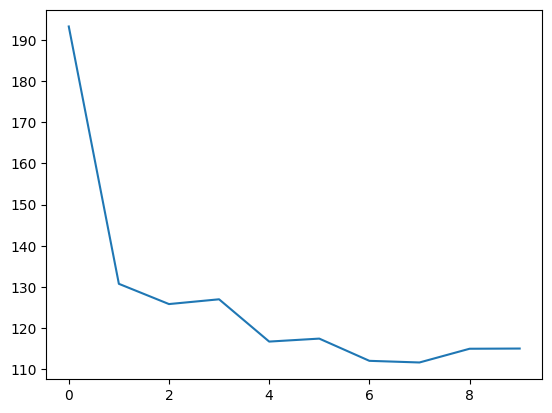

In [2]:
import matplotlib.pyplot as plt
plt.plot(trainer.recon_loss_history)

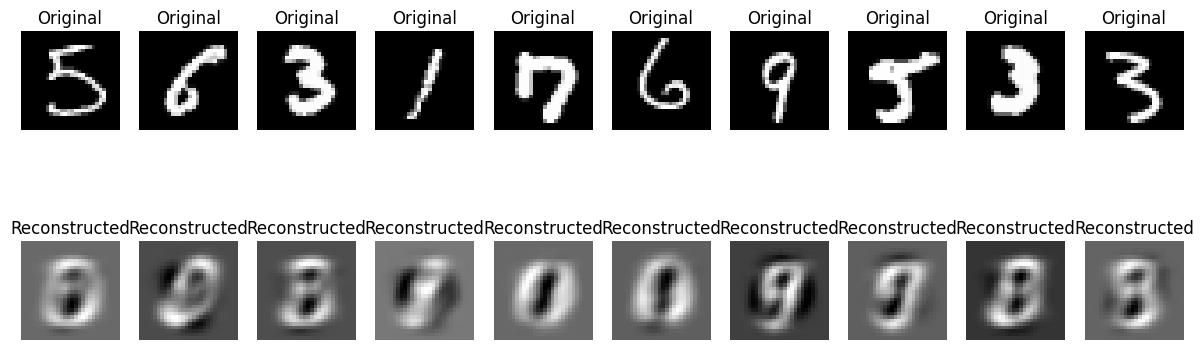

In [3]:
visualize_reconstruction(trainer, x_test)

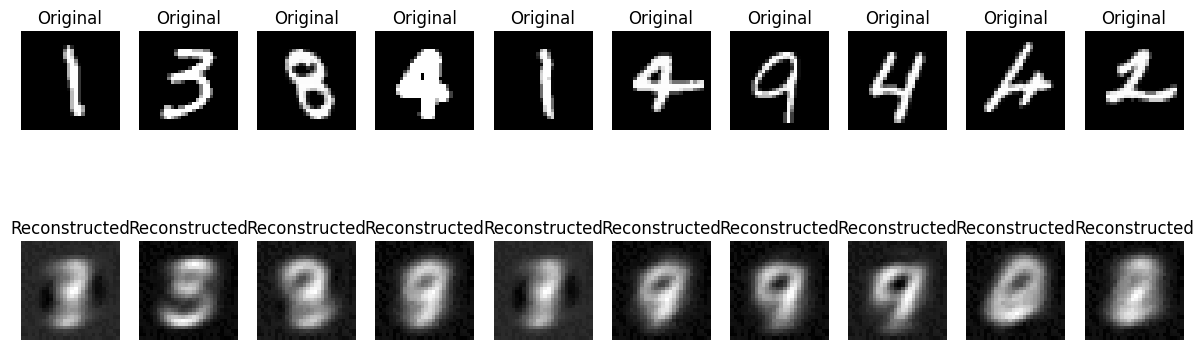

In [5]:
visualize_reconstruction(trainer, x_test)

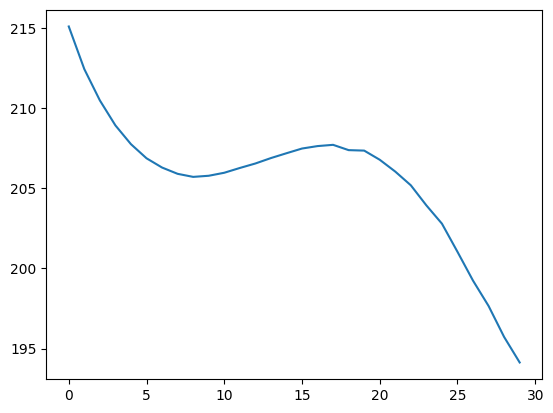

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent_space(encoder, test_data, labels, latent_dim=2, sample_size=1000):
    """
    Визуализация латентного пространства с использованием t-SNE.

    :param encoder: Тренированный энкодер (должен возвращать mu, logvar).
    :param test_data: Тестовые данные (например, изображения MNIST).
    :param labels: Метки тестовых данных.
    :param latent_dim: Размер латентного пространства.
    :param sample_size: Количество точек для визуализации.
    """
    # Выбор подмножества данных
    indices = np.random.choice(len(test_data), sample_size, replace=False)
    sampled_data = test_data[indices]
    sampled_labels = labels[indices]

    # Пропуск данных через энкодер
    latent_representations = []
    for img in sampled_data:
        mu, _ = encoder.forward(img.reshape(1, -1))  # Только mu из z ~ N(mu, sigma^2)
        latent_representations.append(mu.flatten())
    latent_representations = np.array(latent_representations)

    # Если латентное пространство не 2D, используем t-SNE
    if latent_dim > 2:
        tsne = TSNE(n_components=2, random_state=42)
        latent_representations_2d = tsne.fit_transform(latent_representations)
    else:
        latent_representations_2d = latent_representations

    # Визуализация
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        latent_representations_2d[:, 0],
        latent_representations_2d[:, 1],
        c=sampled_labels,
        cmap='tab10',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Digit Labels')
    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


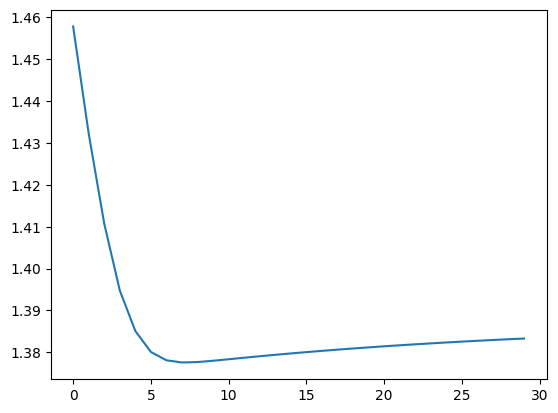

In [ ]:
visualize_latent_space(trainer.encoder, test_data=x_test, mnist_test_labels  )

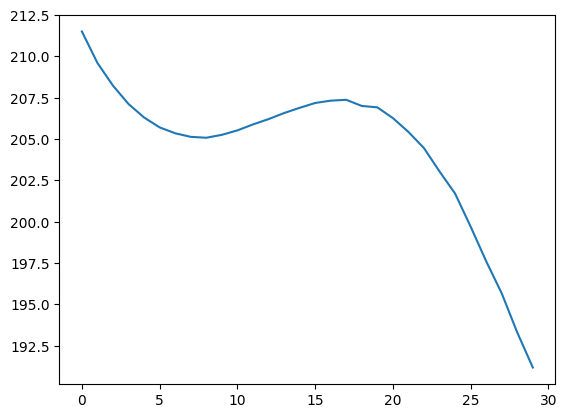

In [7]:
from matplotlib import pyplot as plt

plt.plot(trainer.recon_loss_history)

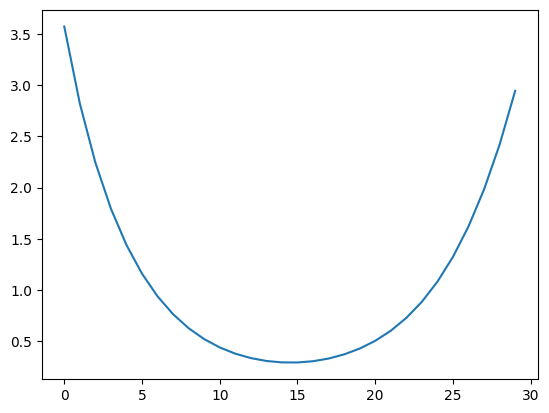

: 

In [ ]:
from matplotlib import pyplot as plt

plt.plot(trainer.kl_loss_history)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_reconstruction(vae_trainer, x_test, num_images=10):
    """
    Visualize the reconstruction of images by the VAE.
    """
    # Select random images
    idx = np.random.choice(len(x_test), num_images, replace=False)
    original_images = x_test[idx]

    # Get reconstructed images
    reconstructed_images, _, _ = vae_trainer.forward(original_images)

    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        
        # Reconstructed images
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    plt.show()

def visualize_latent_space(vae_trainer, x_test, y_test):
    """
    Visualize the latent space for a 2D latent dimension.
    """
    # Encode images to latent space
    mu, _ = vae_trainer.encoder.forward(x_test)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='viridis', s=2)
    plt.colorbar(scatter, label="Class")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

def generate_samples(vae_trainer, grid_size=10, latent_range=(-3, 3)):
    """
    Generate images by sampling the latent space.
    """
    # Create a grid of latent space values
    grid_x = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid_y = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)

    # Decode the grid
    generated_images = vae_trainer.decoder.forward(grid)

    # Plot the generated images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    for i in range(grid_size):
        for j in range(grid_size):
            img = generated_images[i * grid_size + j].reshape(28, 28)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.show()

visualize_reconstruction(vae_trainer, x_test)
visualize_latent_space(vae_trainer, x_test, y_test)
generate_samples(vae_trainer)


NameError: name 'vae_trainer' is not defined